In [1]:
import numpy as np
from scipy import signal, interpolate
import quaternion
import itertools

import os

import matplotlib.pyplot as plt

from copy import copy

import h5py

import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6  # that's default image size for this interactive session
plt.rcParams['axes.formatter.useoffset'] = False

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
from process_imu import IMU

In [4]:
datadir = '/Users/etytel01/Documents/Acceleration/rawdata/data_2017_07_28'
zplus_axis_file = 'static_straight_up.hdf5'
xplus_axis_file = 'static_laying_flat_reversed.hdf5'
yneg_axis_file = 'static_sticking_out.hdf5'
calib_file = 'static_straight_up.hdf5'
rot_file = 'rotate_only.hdf5'
trans_file = 'translate_only.hdf5'
rot_trans_file = 'rotate_and_translate.hdf5'

In [5]:
axisfiles = [zplus_axis_file, xplus_axis_file, yneg_axis_file]
axisfiles = [os.path.join(datadir, fn) for fn in axisfiles]
times = [5, 5, 5]

In [6]:
filename = axisfiles

tmax = 0
t = np.array([])
acc = np.zeros((0, 3))
for i, fn in enumerate(filename):
    with h5py.File(fn, 'r') as h5calib:
        acc1 = np.array(h5calib['/data/Accel'])
        t1 = np.array(h5calib['/data/t']) / 1000.0

        acc = np.append(acc, acc1, axis=0)
        t = np.append(t, t1+tmax)
        times[i] += tmax
        tmax += np.max(t1)

In [7]:
times

[5, 15.390000000000001, 26.009999999999998]

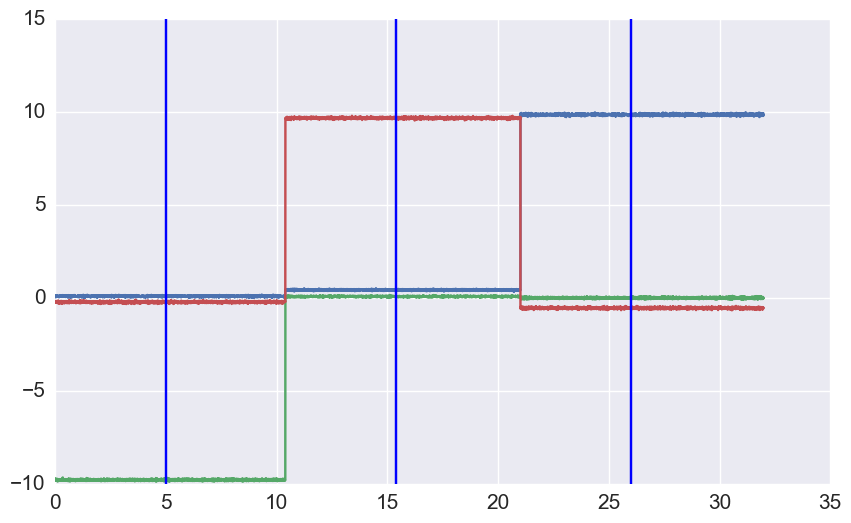

In [8]:
plt.plot(t, acc)
for t1 in times:
    plt.axvline(x=t1)

In [19]:
imu0 = IMU()

In [20]:
fn = os.path.join(datadir, calib_file)
imu0.calibrate(fn, gyro_units='rad/s', acc_units='m/s^2')
imu0.get_inertial_coords(fn, gyro_units='rad/s', acc_units='m/s^2')
imu0.get_world_coordinates(axisfiles, axes=('+z','+x','-y'), times=(5,5,5), acc_units='m/s^2')

In [25]:
beta = imu0.estimate_beta(fn, gyro_units='rad/s')
print np.rad2deg(beta)

0.109790502452


In [11]:
imu0.chip2world_rot

array([[ 0.04641781, -0.99886411,  0.01076427],
       [-0.02042385, -0.01172263, -0.99972268],
       [ 0.9987133 ,  0.04618509, -0.02094479]])

In [37]:
imu = []
enc = []
acc_base = []
tenc = []

for fn in [rot_file, trans_file, rot_trans_file]:
    imu1 = copy(imu0)

    fullfn = os.path.join(datadir, fn)
    imu1.load(fullfn, resamplefreq=200.0)

    imu1.filter(nsamp=10, method='running')

    with h5py.File(fullfn, 'r') as h5file:
        enc1 = np.array(h5file['/data/Encoder'])
        accb1 = np.array(h5file['/data/Accel2'])
        t1 = np.array(h5file['/data/t']).astype(float)
    t1 /= 1000.0
    enc1 *= np.pi / 180.0

    tenc.append(t1)
    imu.append(imu1)
    enc.append(enc1)
    acc_base.append(accb1)

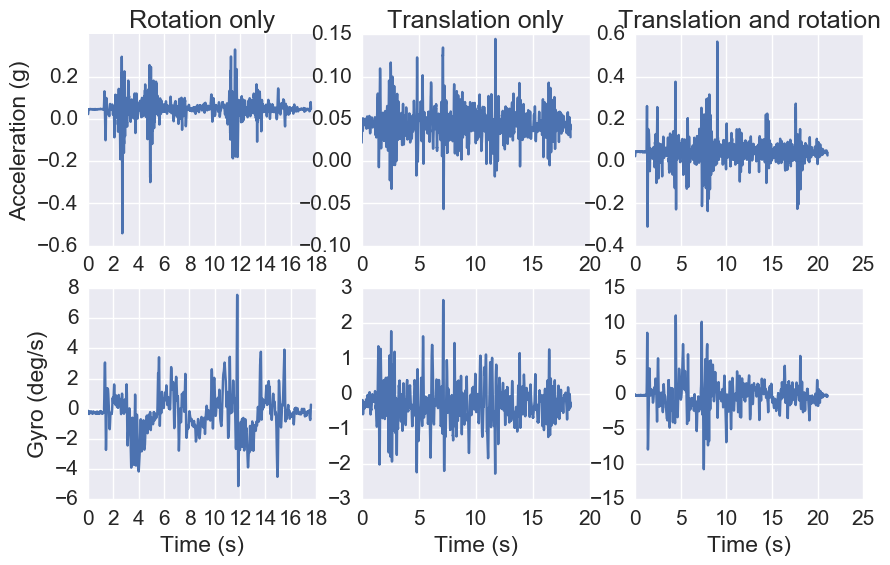

In [13]:
fig, ax = plt.subplots(2,3)
for imu1, ax1 in zip(imu, np.rollaxis(ax, 1)):
    ax1[0].plot(imu1.t, imu1.acc[:, 0]/9.81)
    ax1[1].plot(imu1.t, np.rad2deg(imu1.gyro[:, 2]))
    
ax[0, 0].set_ylabel('Acceleration (g)')
ax[1, 0].set_ylabel('Gyro (deg/s)')

ax[0, 0].set_title('Rotation only')
ax[0, 1].set_title('Translation only')
ax[0, 2].set_title('Translation and rotation')

ax[1, 0].set_xlabel('Time (s)')
ax[1, 1].set_xlabel('Time (s)')
ax[1, 2].set_xlabel('Time (s)')

plt.show()

In [29]:
orient_dsf = []
accdyn_dsf = []
orient_mad = []
accdyn_mad = []
t = []
for imu1 in imu:
    imu1.get_orientation(method='dsf')
    t.append(copy(imu1.t))
    orient_dsf.append(copy(imu1.orient))
    accdyn_dsf.append(copy(imu1.accdyn))
    
    imu1.get_orientation(method='madgwick', beta=beta)
    orient_mad.append(copy(imu1.orient))
    accdyn_mad.append(copy(imu1.accdyn))

In [44]:
enc0 = enc
enc = []
for t1, tenc1, enc1 in zip(t, tenc, enc0):
    enc.append(interpolate.interp1d(tenc1, enc1)(t1))

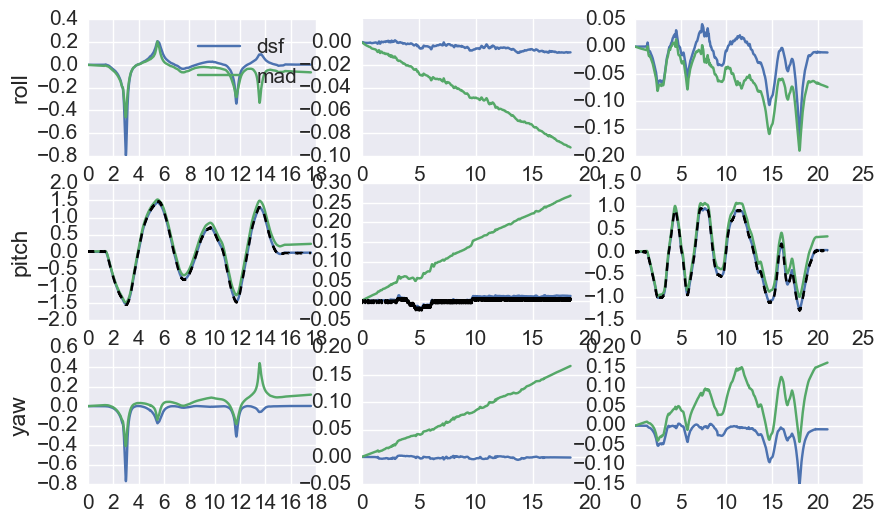

In [49]:
fig, ax = plt.subplots(3, 3)
for t1, orient_dsf1, orient_mad1, enc1, ax1 in zip(t, orient_dsf, orient_mad, enc, np.rollaxis(ax, 1)):
    ax1[0].plot(t1, orient_dsf1[:, 0], label='dsf')
    ax1[0].plot(t1, orient_mad1[:, 0], label='mad')
    
    ax1[1].plot(t1, orient_dsf1[:, 1], label='dsf')
    ax1[1].plot(t1, orient_mad1[:, 1], label='mad')
    ax1[1].plot(t1, enc1[0] - enc1, 'k--')

    ax1[2].plot(t1, orient_dsf1[:, 2], label='dsf')
    ax1[2].plot(t1, orient_mad1[:, 2], label='mad')
    
ax[0, 0].legend()
ax[0, 0].set_ylabel('roll')
ax[1, 0].set_ylabel('pitch')
ax[2, 0].set_ylabel('yaw')
plt.show()

In [ ]:
def get_orient_error(o, otrue):
    qerr = [] 
    for o1, otrue1 in zip(o, otrue):
        q1 = imu._eul2quat(o1)
        qtrue1 = imu._eul2quat(otrue1)
        
        err1 = np.arccos(np.sum(q1.components * qtrue1.components))
        
        qerr.append(err1)

In [ ]:
fig, ax = plt.subplots(2, 3)

for t1, orient_dsf1, orient_mad1, enc1, ax1 in zip(t, orient_dsf, orient_mad, enc, np.rollaxis(ax, 1)):
    qd1 =

TODO: Estimate acceleration due to rotation of the arm and subtract

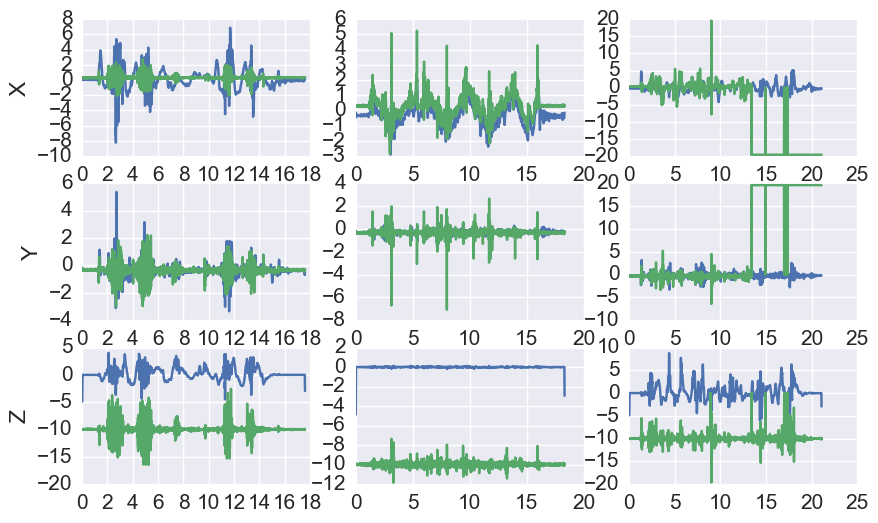

In [18]:
fig, ax = plt.subplots(3, 3)
for t1, accdyn1, tenc1, accbase1, ax1 in zip(t, accdyn, tenc, acc_base, np.rollaxis(ax, 1)):
    ax1[0].plot(t1, accdyn1[:, 0])
    ax1[0].plot(tenc1, -accbase1[:, 0])
    ax1[1].plot(t1, accdyn1[:, 1])
    ax1[1].plot(tenc1, -accbase1[:, 1])
    ax1[2].plot(t1, accdyn1[:, 2])
    ax1[2].plot(tenc1, -accbase1[:, 2])
ax[0, 0].set_ylabel('X')
ax[1, 0].set_ylabel('Y')
ax[2, 0].set_ylabel('Z')